# Examples for the AbsComponent Class (v1.1)

In [10]:
%matplotlib inline

# suppress warnings for these examples
import warnings
warnings.filterwarnings('ignore')

In [11]:
# import
try:
    import seaborn as sns; sns.set_style("white")
except:
    pass
import numpy as np
from astropy.table import QTable
import astropy.units as u
from linetools.spectralline import AbsLine
from linetools.isgm import utils as ltiu
from linetools.analysis import absline as laa
from linetools.spectra import io as lsio
from linetools.isgm.abscomponent import AbsComponent
import linetools.analysis.voigt as lav

import imp
lt_path = imp.find_module('linetools')[1]

## Instantiate

### Standard

In [12]:
abscomp = AbsComponent((10.0*u.deg, 45*u.deg), (14,2), 1.0, [-300,300]*u.km/u.s)
abscomp

<AbsComponent: 00:40:00 +45:00:00, Name=SiII_z1.00000, Zion=(14,2), Ej=0 1 / cm, z=1, vlim=-300 km / s,300 km / s>

### From AbsLines

#### From one line

In [13]:
lya = AbsLine(1215.670*u.AA, z=2.92939)
lya.limits.set([-300.,300.]*u.km/u.s)  # vlim

In [14]:
abscomp = AbsComponent.from_abslines([lya])
print(abscomp)
abscomp._abslines

<AbsComponent: 00:00:00 +00:00:00, Name=HI_z2.92939, Zion=(1,1), Ej=0 1 / cm, z=2.92939, vlim=-300 km / s,300 km / s>


[<AbsLine: HI 1215, z=2.9294 wrest=1215.6700 Angstrom, f=0.4164>]

#### From multiple

In [15]:
lyb = AbsLine(1025.7222*u.AA, z=lya.z)
lyb.limits.set([-300.,300.]*u.km/u.s)  # vlim

In [16]:
abscomp = AbsComponent.from_abslines([lya,lyb])
print(abscomp)
abscomp._abslines

<AbsComponent: 00:00:00 +00:00:00, Name=HI_z2.92939, Zion=(1,1), Ej=0 1 / cm, z=2.92939, vlim=-300 km / s,300 km / s>


[<AbsLine: HI 1215, z=2.9294 wrest=1215.6700 Angstrom, f=0.4164>,
 <AbsLine: HI 1025, z=2.9294 wrest=1025.7222 Angstrom, f=0.07914>]

In [17]:
#### Define from QTable and make an spectrum model

# We first create a QTable with the most relevant information for defining AbsComponents
tab = QTable()
tab['ion_name'] = ['HI', 'HI']
tab['z_comp'] = [0.2, 0.15]  # you should put the right redshifts here
tab['logN'] = [19., 19.]  # you should put the right column densities here
tab['sig_logN'] = [0.1, 0.1]  # you should put the right column density uncertainties here
tab['flag_logN'] = [1, 1] # Flags correspond to linetools notation
tab['RA'] = [0, 0]*u.deg  # you should put the right coordinates here
tab['DEC'] = [0, 0]*u.deg  # you should put the right coordinates here
tab['vmin'] = [-100, -100]*u.km/u.s  # This correspond to the velocity lower limit for the absorption components
tab['vmax'] = [100, 100]*u.km/u.s  # This correspond to the velocity upper limit for the absorption components
tab['b'] = [20, 20]*u.km/u.s  # you should put the right Dopper parameters here 

# We now use this table to create a list of AbsComponents
complist = ltiu.complist_from_table(tab) 

# Now we need to add AbsLines to the component that are relevant for your spectrum
# This will be done by knowing the observed wavelength limits
wvlim = [1150, 1750]*u.AA
for comp in complist:
    comp.add_abslines_from_linelist(llist='HI') # you can also use llist="ISM" if you have other non HI components

# Finally, we can create a model spectrum for each AbsCompontent
wv_array = np.arange(1150,1750, 0.01) * u.AA  # This should match your spectrum wavelength array 
model_1 = ltav.voigt_from_components(wv_array, [complist[0]])

Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


## Methods

### Generate a Component Table

In [18]:
lya.attrib['logN'] = 14.1
lya.attrib['sig_logN'] = 0.15
lya.attrib['flag_N'] = 1
laa.linear_clm(lya.attrib)
lyb.attrib['logN'] = 14.15
lyb.attrib['sig_logN'] = 0.19
lyb.attrib['flag_N'] = 1
laa.linear_clm(lyb.attrib)

(<Quantity 141253754462275.53 1 / cm2>, <Quantity 61797269977312.6 1 / cm2>)

In [19]:
abscomp = AbsComponent.from_abslines([lya,lyb])
comp_tbl = abscomp.build_table()
comp_tbl

wrest,z,flag_N,logN,sig_logN
Angstrom,,,,
float64,float64,int64,float64,float64
1215.67,2.92939,1,14.1,0.15
1025.7222,2.92939,1,14.15,0.19


### Synthesize multiple components

In [20]:
SiIItrans = ['SiII 1260', 'SiII 1304', 'SiII 1526']
SiIIlines = []
for trans in SiIItrans:
    iline = AbsLine(trans, z=2.92939)
    iline.attrib['logN'] = 12.8 + np.random.rand()
    iline.attrib['sig_logN'] = 0.15
    iline.attrib['flag_N'] = 1
    iline.limits.set([-300.,50.]*u.km/u.s)  # vlim
    _,_ = laa.linear_clm(iline.attrib)
    SiIIlines.append(iline)
SiIIcomp = AbsComponent.from_abslines(SiIIlines)
SiIIcomp.synthesize_colm()

In [21]:
SiIIlines2 = []
for trans in SiIItrans:
    iline = AbsLine(trans, z=2.92939)
    iline.attrib['logN'] = 13.3 + np.random.rand()
    iline.attrib['sig_logN'] = 0.15
    iline.attrib['flag_N'] = 1
    iline.limits.set([50.,300.]*u.km/u.s)  # vlim
    _,_ = laa.linear_clm(iline.attrib)
    SiIIlines2.append(iline)
SiIIcomp2 = AbsComponent.from_abslines(SiIIlines2)
SiIIcomp2.synthesize_colm()

In [22]:
abscomp.synthesize_colm()
[abscomp,SiIIcomp,SiIIcomp2]

[<AbsComponent: 00:00:00 +00:00:00, Name=HI_z2.92939, Zion=(1,1), Ej=0 1 / cm, z=2.92939, vlim=-300 km / s,300 km / s, logN=14.1172, sig_logN=0.117912, flag_N=1>,
 <AbsComponent: 00:00:00 +00:00:00, Name=SiII_z2.92939, Zion=(14,2), Ej=0 1 / cm, z=2.92939, vlim=-300 km / s,50 km / s, logN=13.2701, sig_logN=0.0913738, flag_N=1>,
 <AbsComponent: 00:00:00 +00:00:00, Name=SiII_z2.92939, Zion=(14,2), Ej=0 1 / cm, z=2.92939, vlim=50 km / s,300 km / s, logN=13.5902, sig_logN=0.0871858, flag_N=1>]

In [23]:
synth_SiII = ltiu.synthesize_components([SiIIcomp,SiIIcomp2])
synth_SiII

<AbsComponent: 00:00:00 +00:00:00, Name=SiII_z2.92939, Zion=(14,2), Ej=0 1 / cm, z=2.92939, vlim=-300 km / s,300 km / s, logN=13.7601, sig_logN=0.0659686, flag_N=1>

### Generate multiple components from abslines

In [24]:
comps = ltiu.build_components_from_abslines([lya,lyb,SiIIlines[0],SiIIlines[1]])
comps

[<AbsComponent: 00:00:00 +00:00:00, Name=HI_z2.92939, Zion=(1,1), Ej=0 1 / cm, z=2.92939, vlim=-300 km / s,300 km / s>,
 <AbsComponent: 00:00:00 +00:00:00, Name=SiII_z2.92939, Zion=(14,2), Ej=0 1 / cm, z=2.92939, vlim=-300 km / s,50 km / s>]

### Generate an Ion Table

In [25]:
tbl = ltiu.iontable_from_components([abscomp,SiIIcomp,SiIIcomp2])
tbl

Z,ion,A,Ej,z,vmin,vmax,flag_N,logN,sig_logN
,,,1 / cm,,km / s,km / s,,,
int64,int64,int64,float64,float64,float64,float64,int64,float64,float64
1,1,0,0.0,2.92939,-300.0,300.0,1,14.1172024817,0.117911610801
14,2,0,0.0,2.92939,-300.0,300.0,1,13.7600597799,0.0659686064528


### Stack plot

#### Load a spectrum

In [26]:
xspec = lsio.readspec(lt_path+'/spectra/tests/files/UM184_nF.fits')
lya.analy['spec'] = xspec
lyb.analy['spec'] = xspec

#### Show

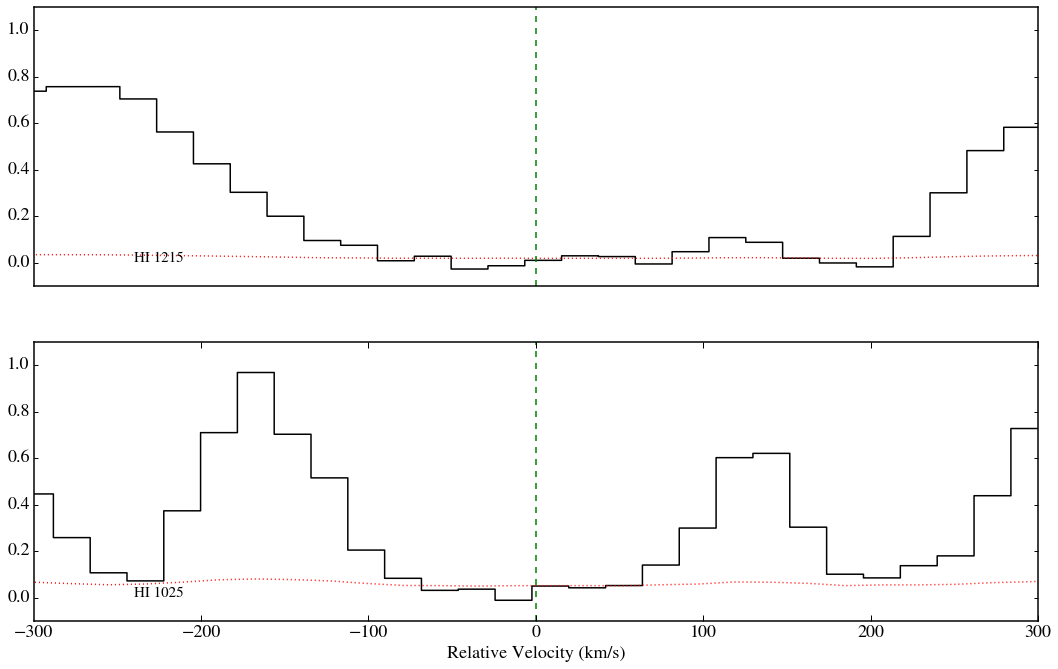

In [27]:
abscomp = AbsComponent.from_abslines([lya,lyb])
abscomp.stack_plot()